In [125]:
# analysis
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns


# preprocessingn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import QuantileTransformer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import mean_squared_error, make_scorer


# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, RepeatedKFold, KFold
import optuna

# classification
from lightgbm import LGBMClassifier

# regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.en

import warnings

warnings.filterwarnings('ignore')

In [2]:
# loading datasets
train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv")
sub = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv")
original = pd.read_csv("/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv")

train.head()

,id,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96
3,3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05
4,4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19


In [3]:
# dropping duplicates in original
original = original[~original.drop("Strength", axis=1).duplicated(keep=False)]
train = train[train['AgeInDays'] != 49]

In [4]:
from functools import partial
from copy import deepcopy

rmse = partial(mean_squared_error, squared=False)

In [5]:
# class Splitter:
    
#     def __init__(self, test_size=0.2, kfold=True, n_splits=5):
#         self.test_size = test_size
#         self.kfold = kfold 
#         self.n_splits= n_splits
        
#     def split_data(self, X, y, random_state_list):
#         if self.kfold:
#             for random_state in random_state_list:
#                 kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
#                 for train_idx, val_idx in kf.split(X, y):
#                     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#                     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
#                     yield X_train, X_val, y_train, y_val, train_idx, val_idx
#         else:
#             for random_state in random_state_list:
#                 X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
#                 yield X_train, X_val, y_train, y_val
        

In [6]:
class Splitter:
    
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold 
        self.n_splits= n_splits
        
    def split_data(self, X, y, random_state):
        if self.kfold:
            kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
            for train_idx, val_idx in kf.split(X, y):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                yield X_train, X_val, y_train, y_val, train_idx, val_idx
        else:
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=self.test_size, random_state=random_state)
            yield X_train, X_val, y_train, y_val
        

In [7]:
X = train.drop(['id', "Strength"], axis=1)
y = train['Strength']

In [40]:
def dump_model(models_log, model_name, description, train_score, valid_score):
    info = {'Model name': model_name, 'Description': description, 'Local cv train score': train_score,
               "Local cv valid score": valid_score}
            
    models_log = models_log.append(info, ignore_index=True)
    
    return models_log


def submission_csv(predictions):
    df = pd.DataFrame()
    df['id'] = test['id']
    df['Strength'] = predictions
    
    return df


models_log = pd.DataFrame(columns=['Model name', "Description", 'Local cv train score', "Local cv valid score"])

In [55]:
def evaluate_model(model_name, model, _X, _y, n_splits=5, random_state_list=[0, 5, 10]):
    len_y = len(_y)
    len_states = len(random_state_list)
    
    oof_preds = np.zeros(len_y * len_states).reshape(len_states, len_y)
    models = []
    scores_train = []
    
    for index, random_state in enumerate(random_state_list):
        splitter = Splitter(n_splits=n_splits)
        splits = 0
        for X_train, X_val, y_train, y_val, train_idx, val_idx in splitter.split_data(_X, _y, random_state):
            model = model
            model.fit(X_train, y_train)
            oof_preds[index, val_idx] = model.predict(X_val).squeeze()
            models.append(deepcopy(model))

            score_train = rmse(y_train, model.predict(X_train))
            scores_train.append(score_train)
                        
            score_valid_split = rmse(y_val, model.predict(X_val).squeeze())
            print(f"seed {random_state} and split {splits} score {score_valid_split}")
            splits += 1
        
        
    return models, oof_preds, np.mean(scores_train), rmse(_y, np.mean(oof_preds, axis=0))

In [41]:
models = {
    "Ridge": Ridge(random_state=0),
    "Lasso": Lasso(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "GradientBoostRegressor": GradientBoostingRegressor(random_state=0),
    "HistGradientBoostingRegressor":  HistGradientBoostingRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "CatBoostRegressor": CatBoostRegressor(random_state=0, verbose=False),
    "LGBMRegressor": LGBMRegressor(random_state=0),
    "SVR": SVR(),
}

n_splits = 8
random_state_list = [0, 5, 10]
pipelines = {}
oof_predictions = {}

for model_name, model in models.items():
    print("#"*10, f"Training model {model_name} with {n_splits} splits and {len(random_state_list)} seeds", "#"*15)       
    _models, _oof_preds, _train_score, _valid_score = evaluate_model("Gradient", model, X, y, n_splits=n_splits, 
                                                             random_state_list=random_state_list) 
    
    pipelines[model_name] = _models
    oof_predictions[model_name] = _oof_preds.mean(axis=0)
    models_log = dump_model(models_log, model_name, np.nan, _train_score, _valid_score) 

########## Training model Ridge with 8 and 3 seeds ###############
seed 0 and split 0 score 14.620314280506715
seed 0 and split 1 score 14.483871015814772
seed 0 and split 2 score 14.694781476441708
seed 0 and split 3 score 14.453626107697575
seed 0 and split 4 score 15.59624302568627
seed 0 and split 5 score 14.318360684356154
seed 0 and split 6 score 14.064258029790095
seed 0 and split 7 score 14.533116625704862
seed 5 and split 0 score 15.329043146369758
seed 5 and split 1 score 14.059204709451329
seed 5 and split 2 score 14.509603462698978
seed 5 and split 3 score 14.369640267882554
seed 5 and split 4 score 14.428550299475324
seed 5 and split 5 score 15.011509323987559
seed 5 and split 6 score 14.562317647792778
seed 5 and split 7 score 14.477855582200837
seed 10 and split 0 score 14.14042700444084
seed 10 and split 1 score 15.095085931708354
seed 10 and split 2 score 14.212268236370608
seed 10 and split 3 score 14.836077531217132
seed 10 and split 4 score 14.291321790522812
seed 1

In [50]:
cols = train.drop(columns=['Strength', 'id']).columns.tolist()
train_agg = train.groupby(by=cols)['Strength'].median().reset_index()
X_agg = train_agg.drop('Strength', axis=1)
y_agg = train_agg['Strength']

In [61]:
n_splits = 8
random_state_list = [0, 5, 10]
for model_name, model in models.items():
    print("#"*10, f"Training model {model_name} with {n_splits} splits and {len(random_state_list)} seeds", "#"*15)       
    _models, _oof_preds, _train_score, _valid_score = evaluate_model("Gradient", model, X_agg, y_agg, n_splits=n_splits, random_state_list=random_state_list) 
    
    pipelines[model_name+"_grouped"] = _models
    oof_predictions[model_name+"_grouped"] = _oof_preds.mean(axis=0)
    models_log = dump_model(models_log, model_name, "Grouped duplicates in train", _train_score, _valid_score) 

########## Training model Ridge with 8 splits and 3 seeds ###############
seed 0 and split 0 score 14.700860874914493
seed 0 and split 1 score 14.048065448451746
seed 0 and split 2 score 14.589775509918423
seed 0 and split 3 score 13.702401134948573
seed 0 and split 4 score 14.099532396143994
seed 0 and split 5 score 14.683294128886875
seed 0 and split 6 score 15.94243326771964
seed 0 and split 7 score 13.508351235480355
seed 5 and split 0 score 15.368383394412616
seed 5 and split 1 score 14.305996694733858
seed 5 and split 2 score 15.008329031460978
seed 5 and split 3 score 14.438741137960276
seed 5 and split 4 score 12.597265244651817
seed 5 and split 5 score 13.887628947889134
seed 5 and split 6 score 14.370947532938642
seed 5 and split 7 score 15.230717856769118
seed 10 and split 0 score 14.015180260718788
seed 10 and split 1 score 14.365380881968969
seed 10 and split 2 score 14.52831365089332
seed 10 and split 3 score 14.543562003609008
seed 10 and split 4 score 14.465229740496042

In [64]:
models_log.sort_values(by="Local cv valid score")

,Model name,Description,Local cv train score,Local cv valid score
12,GradientBoostRegressor,Grouped duplicates in train,10.846982,11.920756
3,GradientBoostRegressor,NaN,11.507415,12.118381
15,CatBoostRegressor,Grouped duplicates in train,8.207625,12.152542
13,HistGradientBoostingRegressor,Grouped duplicates in train,8.508878,12.195188
16,LGBMRegressor,Grouped duplicates in train,8.503079,12.216297
4,HistGradientBoostingRegressor,NaN,10.243218,12.266537
6,CatBoostRegressor,NaN,9.986958,12.280990
7,LGBMRegressor,NaN,10.238005,12.285807
11,RandomForestRegressor,Grouped duplicates in train,4.695839,12.391682
2,RandomForestRegressor,NaN,8.111953,12.786283


In [69]:
def predict_test(models, X_test, n_splits=5, n_repeats=3):
    test_preds = np.zeros(n_splits * n_repeats * len(X_test)).reshape(n_splits * n_repeats, len(X_test))
    for index, model in enumerate(models):
        preds = model.predict(X_test)
        test_preds[index, range(len(preds))] = preds
        
    return test_preds

test_preds = predict_test(pipelines["GradientBoostRegressor_grouped"], test.drop("id", axis=1), n_splits=n_splits, n_repeats=3)

In [71]:
test_preds_final = test_preds.mean(axis=0)

In [73]:
grad_agg_df = submission_csv(test_preds_final)
grad_agg_df.to_csv("grad_agg_df.csv", index=False)

Original difference

In [74]:
join_cols = [
    'CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
    'WaterComponent', 'SuperplasticizerComponent',
    'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'Strength'
]

In [75]:
df_play = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv")
df_play_test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv")

df_datas = pd.read_csv("/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv")
df_datas = df_datas.rename(columns={"CementComponent ": "CementComponent"})

print(df_datas.shape[0], df_play.shape[0])

1030 5407


In [76]:
dict_replace = {}
for coll in join_cols[:-1]:
    # coll = "CoarseAggregateComponent"    
    # find res_j DataFrame
    res_j = df_play[[coll]].drop_duplicates().iloc[:].merge(
        df_datas.rename(columns={coll: f"{coll}__base"})[[f"{coll}__base"]].drop_duplicates().iloc[:],
        how="outer", left_on=coll, right_on=f"{coll}__base", indicator=True
    ).sort_values(by=[f"{coll}"])
        
    # iterate by values
    for val in res_j.iterrows():
        play_col = val[1][f"{coll}"]
        base_col = val[1][f"{coll}__base"]
        if pd.isnull(base_col):
            # find min index
            min_index = (res_j[f"{coll}__base"] - play_col).dropna().abs().idxmin()
            dict_replace[f"{coll}__play__{play_col}"] = res_j.loc[min_index][f"{coll}__base"]

In [77]:
len(dict_replace)

365

In [78]:
for key in dict_replace:
    df_play[key.split("__")[0]] = df_play[key.split("__")[0]].replace(float(key.split("__")[2]), dict_replace[key])

In [79]:
X_diff = df_play.drop(['id', 'Strength'], axis=1)
y_diff = df_play['Strength']

In [80]:
for model_name, model in models.items():
    print("#"*10, f"Training model {model_name} with {n_splits} splits and {len(random_state_list)} seeds", "#"*15)       
    _models, _oof_preds, _train_score, _valid_score = evaluate_model("Gradient", model, X_diff, y_diff, n_splits=n_splits, random_state_list=random_state_list) 
    
    pipelines[model_name+"_diff"] = _models
    oof_predictions[model_name+"_diff"] = _oof_preds.mean(axis=0)
    models_log = dump_model(models_log, model_name, "diff between org and train", _train_score, _valid_score) 

########## Training model Ridge with 8 splits and 3 seeds ###############
seed 0 and split 0 score 14.44012601745608
seed 0 and split 1 score 14.298077658193337
seed 0 and split 2 score 15.001779537935802
seed 0 and split 3 score 15.056639256923162
seed 0 and split 4 score 14.482743915582558
seed 0 and split 5 score 14.775991883805375
seed 0 and split 6 score 13.960428252024272
seed 0 and split 7 score 14.742000170117857
seed 5 and split 0 score 14.790227793889276
seed 5 and split 1 score 14.400422776363888
seed 5 and split 2 score 14.562499129408721
seed 5 and split 3 score 14.753340414581793
seed 5 and split 4 score 13.72034571346714
seed 5 and split 5 score 14.637543532770135
seed 5 and split 6 score 15.459988951831845
seed 5 and split 7 score 14.494127672504804
seed 10 and split 0 score 14.551680751069838
seed 10 and split 1 score 14.929813733615754
seed 10 and split 2 score 14.580219165425222
seed 10 and split 3 score 14.360987839337358
seed 10 and split 4 score 14.84850190040653


In [85]:
models_log.sort_values(by="Local cv valid score").iloc[:5]

,Model name,Description,Local cv train score,Local cv valid score
12,GradientBoostRegressor,Grouped duplicates in train,10.846982,11.920756
21,GradientBoostRegressor,diff between org and train,11.512341,12.108282
3,GradientBoostRegressor,NaN,11.507415,12.118381
15,CatBoostRegressor,Grouped duplicates in train,8.207625,12.152542
13,HistGradientBoostingRegressor,Grouped duplicates in train,8.508878,12.195188


In [87]:
test_preds_diff = predict_test(pipelines["GradientBoostRegressor_diff"], test.drop("id", axis=1), n_splits=n_splits, n_repeats=3)

In [90]:
test_preds_final = test_preds_diff.mean(axis=0)

grad_diff_df = submission_csv(test_preds_final)
grad_diff_df.to_csv("grad_diff_df.csv", index=False)

In [97]:
df_play_diff_agg = df_play.groupby(cols)['Strength'].median().reset_index()

In [98]:
X_diff_agg = df_play_diff_agg.drop('Strength', axis=1)
y_diff_agg = df_play_diff_agg['Strength']

In [99]:
for model_name, model in models.items():
    print("#"*10, f"Training model {model_name} with {n_splits} splits and {len(random_state_list)} seeds", "#"*15)       
    _models, _oof_preds, _train_score, _valid_score = evaluate_model("Gradient", model, X_diff_agg, y_diff_agg, n_splits=n_splits, random_state_list=random_state_list) 
    
    pipelines[model_name+"_diff_agg"] = _models
    oof_predictions[model_name+"_diff_agg"] = _oof_preds.mean(axis=0)
    models_log = dump_model(models_log, model_name, "diff and grouped between org and train", _train_score, _valid_score) 

########## Training model Ridge with 8 splits and 3 seeds ###############
seed 0 and split 0 score 13.88763570922676
seed 0 and split 1 score 14.397555822279825
seed 0 and split 2 score 14.457306331317469
seed 0 and split 3 score 14.203775695858685
seed 0 and split 4 score 14.510506767664884
seed 0 and split 5 score 14.561543828724222
seed 0 and split 6 score 14.3225849543761
seed 0 and split 7 score 14.888714326245251
seed 5 and split 0 score 14.908435219377278
seed 5 and split 1 score 15.009028574913348
seed 5 and split 2 score 14.490023529087637
seed 5 and split 3 score 13.931548908593674
seed 5 and split 4 score 15.19622822187787
seed 5 and split 5 score 14.692308972183628
seed 5 and split 6 score 13.750383173066554
seed 5 and split 7 score 13.325871939855471
seed 10 and split 0 score 14.410680133865522
seed 10 and split 1 score 14.868035618953295
seed 10 and split 2 score 14.152565758358444
seed 10 and split 3 score 13.567645914207304
seed 10 and split 4 score 14.429272152015004
s

In [100]:
test_preds_diff_agg = predict_test(pipelines["GradientBoostRegressor_diff_agg"], test.drop("id", axis=1), n_splits=n_splits, n_repeats=3)

In [101]:
test_preds_final = test_preds_diff_agg.mean(axis=0)

grad_diff_agg_df = submission_csv(test_preds_final)
grad_diff_agg_df.to_csv("grad_diff_agg_df.csv", index=False)

In [110]:
models_log.sort_values(by='Local cv valid score')

,Model name,Description,Local cv train score,Local cv valid score
30,GradientBoostRegressor,diff and grouped between org and train,10.837505,11.910929
12,GradientBoostRegressor,Grouped duplicates in train,10.846982,11.920756
21,GradientBoostRegressor,diff between org and train,11.512341,12.108282
3,GradientBoostRegressor,NaN,11.507415,12.118381
15,CatBoostRegressor,Grouped duplicates in train,8.207625,12.152542
31,HistGradientBoostingRegressor,diff and grouped between org and train,8.504545,12.188619
13,HistGradientBoostingRegressor,Grouped duplicates in train,8.508878,12.195188
34,LGBMRegressor,diff and grouped between org and train,8.504294,12.210295
16,LGBMRegressor,Grouped duplicates in train,8.503079,12.216297
33,CatBoostRegressor,diff and grouped between org and train,8.182292,12.217662


In [121]:
test_preds = predict_test(_models, test.drop("id", axis=1), n_splits=n_splits, n_repeats=3)

In [122]:
test_preds_final = test_preds.mean(axis=0)

grad_df = submission_csv(test_preds_final)
# grad_diff_df.to_csv("grad_diff_df.csv", index=False)

In [143]:
final_preds = (0.35*grad_df['Strength'] + 0.15*grad_agg_df['Strength'] + 0.15*grad_diff_agg_df['Strength'] + 0.35*grad_diff_df['Strength'])

In [144]:
final_preds

0       49.400346
1       20.486781
2       34.089036
3       48.166177
4       30.924155
          ...    
3600    31.410985
3601    36.249883
3602    39.774894
3603    33.611509
3604    20.544506
Name: Strength, Length: 3605, dtype: float64

In [145]:
grad_ensemble_df = submission_csv(final_preds)
grad_ensemble_df.to_csv("grad_ensemble_modified_df.csv", index=False)

Flamml hyper parametertuning

In [107]:
!pip install flaml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 5.4 MB/s eta 0:00:00a 0:00:01


In [108]:
from flaml import AutoML 

In [109]:
automl_reg = AutoML()

In [ ]:
automl_reg.fit(X, y, task="regression", estimator_list=['rf'])

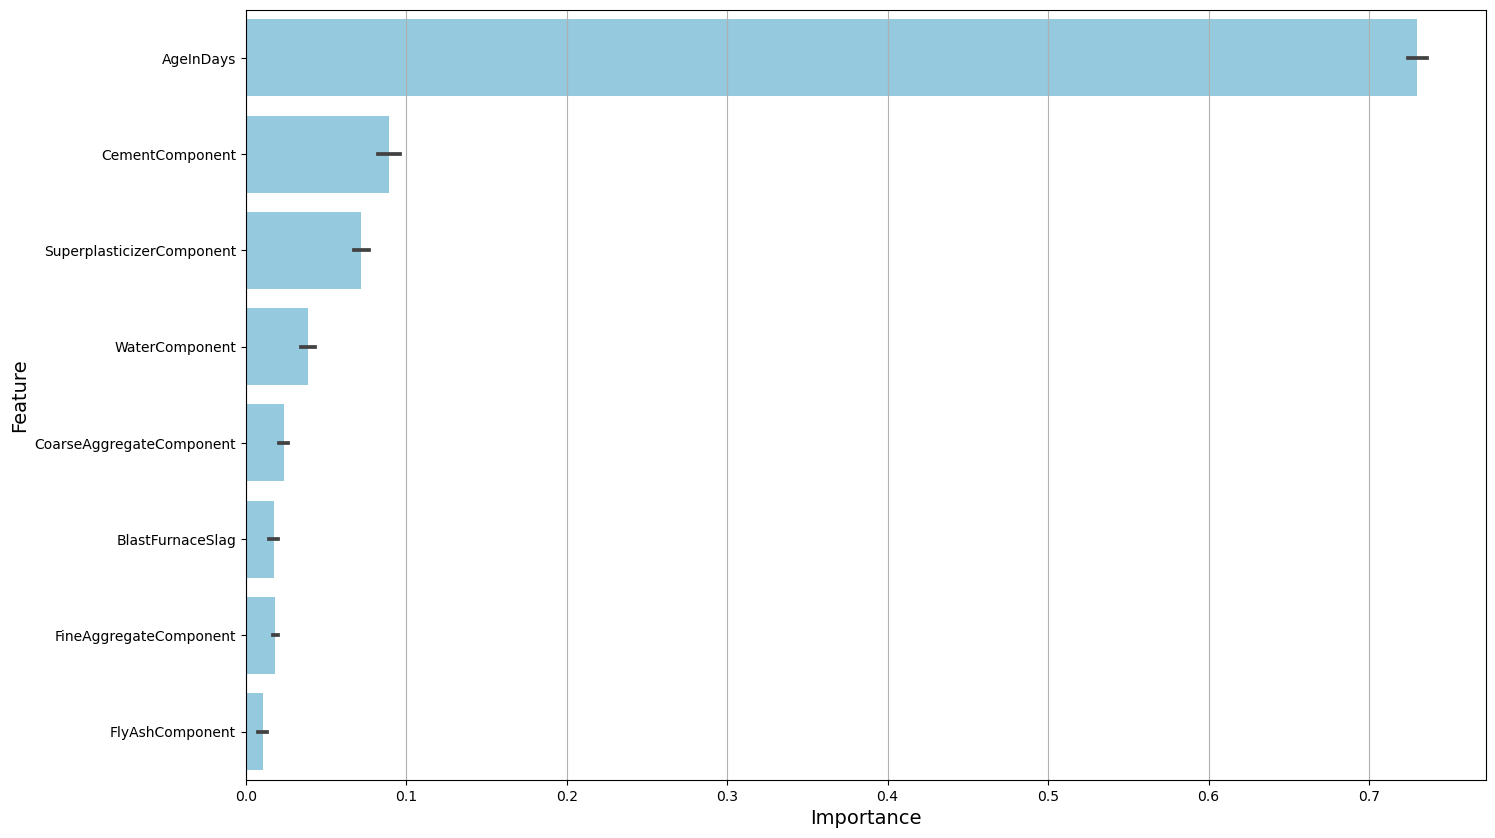

In [125]:
def plot_importance(models, X_test, n_splits=5, n_repeats=3):
    features = X_test.columns.tolist()
    feature_importance = pd.DataFrame()
    for model in models:
        _df = pd.DataFrame()
        _df['importance'] = model.feature_importances_
        _df["features"] = pd.Series(features)
        _df = _df.sort_values(by='importance', ascending=False)
        feature_importance = pd.concat([feature_importance, _df])
        
                
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    plt.figure(figsize=(16, 10))
    sns.barplot(x='importance', y='features', data=feature_importance, color='skyblue', errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
#     plt.title(f'{title} Feature Importance [Top {top}]', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    
    return feature_importance
    
f = plot_importance(models, test.drop('id', axis=1), n_splits=8, n_repeats=3)